<div>
    <img src="images/emlyon.png" style="height:60px; float:left; padding-right:10px; margin-top:5px" />
    <span>
        <h1 style="padding-bottom:5px;"> Smart Supply Chain </h1>
        <a href="https://masters.em-lyon.com/fr/msc-in-data-science-artificial-intelligence-strategy">[Emlyon]</a> MSc in Data Science & Artificial Intelligence Strategy (DSAIS) <br/>
         January 2024, Paris | © Saeed VARASTEH
    </span>
</div>

### Part 05 - Exercises 02 : The Forecast Competition

---
<img src="images/competition.png" style="width:100px; position:absolute; top:-10px; right:0;"/>

__Objective__: Predict three months of item sales at different stores.

__Dataset description__

You are given a file named `store_sales.csv`:

    date - Date
    store - Store ID
    item - Item ID
    sales - Number of items sold at a particular store on a particular date.
    


<font size=50 color="F300FF"><b>FENG Yuekai & ZHANG Fulin</b></font> 

### Import data and modules

#### Import modules

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

#### Import data

In [98]:
sales = pd.read_csv('./data/store/store_sales.csv')
print(sales.shape)
sales.head(5)

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## <span style="color:steelblue;">  Data Exploration  </span>


#### The data in the sales dataset are from which period?

__Hint:__ find the minimum and the maximum of the date.<br/>
__Hint:__ do not forget to convert the `date` column into datetime.

In [99]:
# YOUR CODE
sales.set_index(pd.to_datetime(sales['date']), inplace=True, drop=True)
start_date = sales.index.min()
end_date = sales.index.max()
print('Start Date: {}\nEnd Date: {}'.format(start_date, end_date))

Start Date: 2013-01-01 00:00:00
End Date: 2017-12-31 00:00:00


#### How many unique items and stores are in the dataset?

In [100]:
# YOUR CODE
len(sales['item'].unique())

50

In [101]:
# YOUR CODE
len(sales['store'].unique())

10

#### Plot average monthly sales for the item_id == 10 at store_id == 1

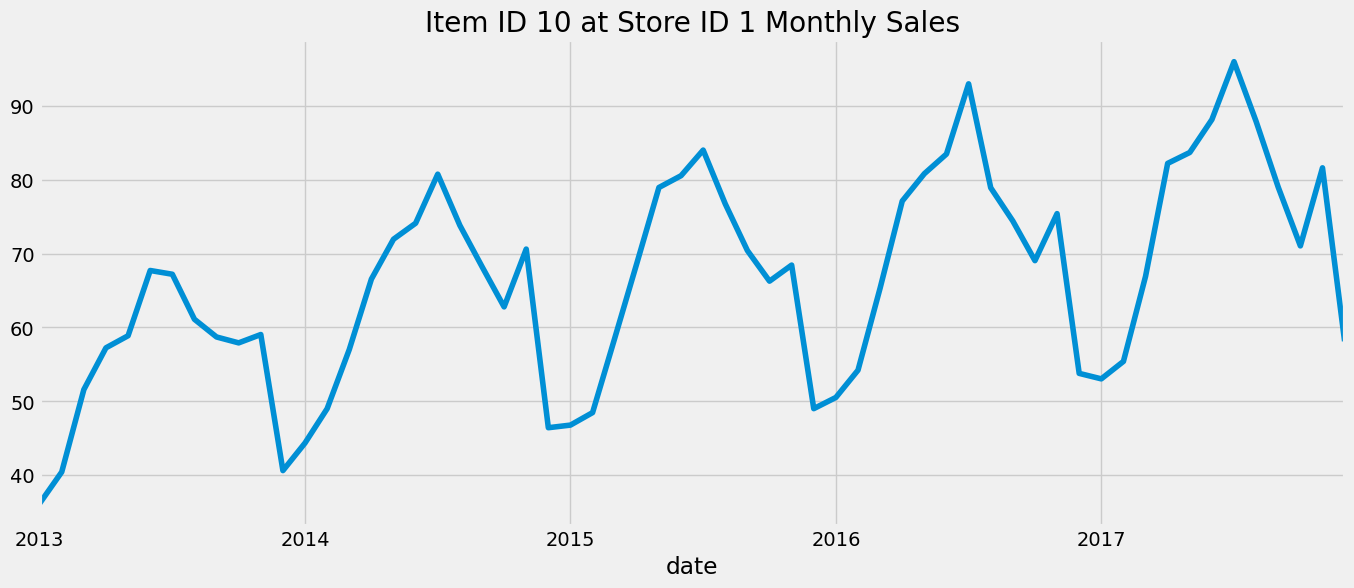

In [102]:
sales[(sales['item'] == 10) & (sales['store'] == 1)].groupby(pd.Grouper(freq='M'))["sales"].mean().plot(kind='line', figsize=(15, 6), title='Item ID 10 at Store ID 1 Monthly Sales');

---

## <span style="color:steelblue;">  Machine Learning for Time Series Forecasting  </span>


### <span style="color:DarkGray;">  Data preprocessing and Feature engineering  </span>

#### Extract some useful features (e.g. lag, rolling mean, datetime) to use in a machine learning model and them to the `sales` DataFrame.

In [103]:
# YOUR CODE
# create some lag features
sales['lag_t1'] = sales.groupby(['item', 'store'])['sales'].shift(1)
sales['lag_t7'] = sales.groupby(['item', 'store'])['sales'].shift(7)
sales['lag_t14'] = sales.groupby(['item', 'store'])['sales'].shift(14)
sales['lag_t28'] = sales.groupby(['item', 'store'])['sales'].shift(28)
sales['lag_t60'] = sales.groupby(['item', 'store'])['sales'].shift(60)

In [104]:
# YOUR CODE
# rolling mean features
sales['rolling_mean_t7'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(7,closed='left').mean()
sales['rolling_mean_t28'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(28,closed='left').mean()
sales['rolling_mean_t60'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(60,closed='left').mean()

In [105]:
# YOUR CODE
# rolling max
sales['rolling_max_t7'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(7,closed='left').max()
sales['rolling_max_t28'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(28,closed='left').max()
sales['rolling_max_t60'] = sales.groupby(['item', 'store'])['sales'].shift(1).rolling(60,closed='left').max()

In [106]:
# split the datatime
sales['quarter'] = sales.index.quarter
sales['month'] = sales.index.month
sales['year'] = sales.index.year
sales['week'] = sales.index.isocalendar().week.astype("int64")
sales['dayofyear'] = sales.index.dayofyear
sales['dayofmonth'] = sales.index.day

In [107]:
sales.dropna(inplace=True)

In [108]:
sales.dtypes

date                 object
store                 int64
item                  int64
sales                 int64
lag_t1              float64
lag_t7              float64
lag_t14             float64
lag_t28             float64
lag_t60             float64
rolling_mean_t7     float64
rolling_mean_t28    float64
rolling_mean_t60    float64
rolling_max_t7      float64
rolling_max_t28     float64
rolling_max_t60     float64
quarter               int64
month                 int64
year                  int64
week                  int64
dayofyear             int64
dayofmonth            int64
dtype: object

In [109]:
sales['date'] = sales.index

### <span style="color:DarkGray;">  Train and test split  </span>

#### Split sales data into the __train__ and __test__ datasets. 

In [110]:
split_date = "2017-10-01"

In [111]:
train = sales.loc[sales.date < split_date].copy()
test = sales.loc[sales.date >= split_date].copy()

In [112]:
print(train.shape)
print(test.shape)

(836500, 21)
(46000, 21)


In [113]:
train

,date,store,item,sales,lag_t1,lag_t7,lag_t14,lag_t28,lag_t60,rolling_mean_t7,...,rolling_mean_t60,rolling_max_t7,rolling_max_t28,rolling_max_t60,quarter,month,year,week,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,,,
2013-03-03,2013-03-03,1,1,20,13.0,11.0,11.0,15.0,11.0,10.857143,...,11.083333,15.0,21.0,21.0,1,3,2013,9,62,3
2013-03-04,2013-03-04,1,1,14,20.0,7.0,10.0,14.0,14.0,10.571429,...,11.083333,15.0,16.0,21.0,1,3,2013,10,63,4
2013-03-05,2013-03-05,1,1,13,14.0,9.0,10.0,9.0,13.0,11.857143,...,11.233333,20.0,20.0,21.0,1,3,2013,10,64,5
2013-03-06,2013-03-06,1,1,17,13.0,9.0,7.0,10.0,10.0,12.857143,...,11.233333,20.0,20.0,21.0,1,3,2013,10,65,6
2013-03-07,2013-03-07,1,1,11,17.0,10.0,13.0,13.0,12.0,13.428571,...,11.233333,20.0,20.0,21.0,1,3,2013,10,66,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-26,2017-09-26,10,50,79,63.0,84.0,70.0,79.0,115.0,85.571429,...,91.666667,99.0,107.0,125.0,3,9,2017,39,269,26
2017-09-27,2017-09-27,10,50,80,79.0,72.0,84.0,79.0,125.0,85.857143,...,91.000000,99.0,107.0,125.0,3,9,2017,39,270,27
2017-09-28,2017-09-28,10,50,82,80.0,89.0,90.0,89.0,110.0,85.142857,...,90.400000,99.0,107.0,125.0,3,9,2017,39,271,28


In [114]:
test

,date,store,item,sales,lag_t1,lag_t7,lag_t14,lag_t28,lag_t60,rolling_mean_t7,...,rolling_mean_t60,rolling_max_t7,rolling_max_t28,rolling_max_t60,quarter,month,year,week,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,2017-10-01,1,1,21,30.0,24.0,30.0,23.0,19.0,24.428571,...,25.000000,37.0,37.0,38.0,4,10,2017,39,274,1
2017-10-02,2017-10-02,1,1,12,21.0,14.0,22.0,12.0,25.0,23.428571,...,25.200000,30.0,37.0,38.0,4,10,2017,40,275,2
2017-10-03,2017-10-03,1,1,18,12.0,18.0,21.0,26.0,26.0,23.000000,...,25.233333,30.0,37.0,38.0,4,10,2017,40,276,3
2017-10-04,2017-10-04,1,1,15,18.0,27.0,20.0,24.0,35.0,22.714286,...,25.016667,30.0,37.0,38.0,4,10,2017,40,277,4
2017-10-05,2017-10-05,1,1,20,15.0,23.0,20.0,29.0,29.0,22.714286,...,24.883333,30.0,37.0,38.0,4,10,2017,40,278,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,2017-12-27,10,50,63,41.0,51.0,67.0,76.0,101.0,62.857143,...,76.716667,76.0,86.0,123.0,4,12,2017,52,361,27
2017-12-28,2017-12-28,10,50,59,63.0,63.0,72.0,73.0,89.0,61.000000,...,76.000000,76.0,86.0,123.0,4,12,2017,52,362,28
2017-12-29,2017-12-29,10,50,74,59.0,75.0,72.0,66.0,69.0,62.714286,...,75.366667,76.0,86.0,123.0,4,12,2017,52,363,29


#### Create input (`x`) and output (`y`) variables
Note: use __sales__ as the output column.

In [115]:
x_train = train.drop(columns=["sales","date"])
y_train = train["sales"]
x_test = test.drop(columns=["sales","date"])
y_test = test["sales"]

In [116]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(836500, 19) (836500,)
(46000, 19) (46000,)


In [117]:
x_train

,store,item,lag_t1,lag_t7,lag_t14,lag_t28,lag_t60,rolling_mean_t7,rolling_mean_t28,rolling_mean_t60,rolling_max_t7,rolling_max_t28,rolling_max_t60,quarter,month,year,week,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,
2013-03-03,1,1,13.0,11.0,11.0,15.0,11.0,10.857143,11.642857,11.083333,15.0,21.0,21.0,1,3,2013,9,62,3
2013-03-04,1,1,20.0,7.0,10.0,14.0,14.0,10.571429,11.357143,11.083333,15.0,16.0,21.0,1,3,2013,10,63,4
2013-03-05,1,1,14.0,9.0,10.0,9.0,13.0,11.857143,11.535714,11.233333,20.0,20.0,21.0,1,3,2013,10,64,5
2013-03-06,1,1,13.0,9.0,7.0,10.0,10.0,12.857143,11.535714,11.233333,20.0,20.0,21.0,1,3,2013,10,65,6
2013-03-07,1,1,17.0,10.0,13.0,13.0,12.0,13.428571,11.678571,11.233333,20.0,20.0,21.0,1,3,2013,10,66,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-26,10,50,63.0,84.0,70.0,79.0,115.0,85.571429,86.928571,91.666667,99.0,107.0,125.0,3,9,2017,39,269,26
2017-09-27,10,50,79.0,72.0,84.0,79.0,125.0,85.857143,85.678571,91.000000,99.0,107.0,125.0,3,9,2017,39,270,27
2017-09-28,10,50,80.0,89.0,90.0,89.0,110.0,85.142857,85.678571,90.400000,99.0,107.0,125.0,3,9,2017,39,271,28


In [118]:
x_test

,store,item,lag_t1,lag_t7,lag_t14,lag_t28,lag_t60,rolling_mean_t7,rolling_mean_t28,rolling_mean_t60,rolling_max_t7,rolling_max_t28,rolling_max_t60,quarter,month,year,week,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,
2017-10-01,1,1,30.0,24.0,30.0,23.0,19.0,24.428571,23.857143,25.000000,37.0,37.0,38.0,4,10,2017,39,274,1
2017-10-02,1,1,21.0,14.0,22.0,12.0,25.0,23.428571,24.000000,25.200000,30.0,37.0,38.0,4,10,2017,40,275,2
2017-10-03,1,1,12.0,18.0,21.0,26.0,26.0,23.000000,23.928571,25.233333,30.0,37.0,38.0,4,10,2017,40,276,3
2017-10-04,1,1,18.0,27.0,20.0,24.0,35.0,22.714286,23.928571,25.016667,30.0,37.0,38.0,4,10,2017,40,277,4
2017-10-05,1,1,15.0,23.0,20.0,29.0,29.0,22.714286,23.642857,24.883333,30.0,37.0,38.0,4,10,2017,40,278,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,10,50,41.0,51.0,67.0,76.0,101.0,62.857143,65.107143,76.716667,76.0,86.0,123.0,4,12,2017,52,361,27
2017-12-28,10,50,63.0,63.0,72.0,73.0,89.0,61.000000,64.142857,76.000000,76.0,86.0,123.0,4,12,2017,52,362,28
2017-12-29,10,50,59.0,75.0,72.0,66.0,69.0,62.714286,63.678571,75.366667,76.0,86.0,123.0,4,12,2017,52,363,29


In [119]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [120]:
s = 'minmax'

if s == 'minmax':
    scaler = MinMaxScaler()
    scaler_mm = MinMaxScaler() 
    scaler_mm.fit(x_train)

    x_train_n = scaler_mm.transform(x_train)
    x_train_n = pd.DataFrame(x_train_n,columns=x_train.columns)

    x_test_n = scaler_mm.transform(x_test)
    x_test_n = pd.DataFrame(x_test_n,columns=x_test.columns)

elif s == 'standard':

    scaler_std = StandardScaler() 
    scaler_std.fit(x_train)

    x_train_n = scaler_std.transform(x_train)
    x_train_n = pd.DataFrame(x_train_n,columns=x_train.columns)

    x_test_n = scaler_std.transform(x_test)
    x_test_n = pd.DataFrame(x_test_n,columns=x_test.columns)
else:
    pass

### <span style="color:DarkGray;"> Model training and validation </span>

#### Train a  model on the train and validate your model on the test dataset (report your SMAPE score)

In [90]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

#### Linear Regression model

In [91]:
%%time
from sklearn.linear_model import LinearRegression

# Fitting the model on train
model = LinearRegression()
model.fit(x_train, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test)

# Evaluating with SMAPE
print(f"LR SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

LR SMAPE: 15.24039543655566
CPU times: user 2.16 s, sys: 312 ms, total: 2.47 s
Wall time: 669 ms


#### Your model

#### Linear Regression model - Scaled data

In [121]:
%%time
if 1:
    from sklearn.linear_model import LinearRegression

    # Fitting the model on train
    model = LinearRegression()
    model.fit(x_train_n, y_train)

    # Predicting the outputs for test
    y_pred = model.predict(x_test_n)

    # Evaluating with SMAPE
    print(f"LR SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

LR SMAPE: 15.240395436555678
CPU times: user 682 ms, sys: 113 ms, total: 795 ms
Wall time: 232 ms


In [122]:
%%time
# catboost

from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(x_train, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test)

# Evaluating with SMAPE
print(f"CatBoost SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

Learning rate set to 0.118558
0:	learn: 26.0417478	total: 94.2ms	remaining: 1m 34s
1:	learn: 23.5684795	total: 123ms	remaining: 1m 1s
2:	learn: 21.4006725	total: 152ms	remaining: 50.5s
3:	learn: 19.5033795	total: 180ms	remaining: 44.8s
4:	learn: 17.8507222	total: 213ms	remaining: 42.3s
5:	learn: 16.4472007	total: 241ms	remaining: 39.9s
6:	learn: 15.2181460	total: 268ms	remaining: 38s
7:	learn: 14.1748501	total: 293ms	remaining: 36.4s
8:	learn: 13.2821422	total: 318ms	remaining: 35s
9:	learn: 12.5126049	total: 342ms	remaining: 33.9s
10:	learn: 11.8433327	total: 368ms	remaining: 33.1s
11:	learn: 11.2876314	total: 393ms	remaining: 32.4s
12:	learn: 10.8275887	total: 418ms	remaining: 31.8s
13:	learn: 10.4314027	total: 444ms	remaining: 31.3s
14:	learn: 10.1023624	total: 469ms	remaining: 30.8s
15:	learn: 9.8273452	total: 492ms	remaining: 30.3s
16:	learn: 9.5976079	total: 517ms	remaining: 29.9s
17:	learn: 9.4057576	total: 543ms	remaining: 29.6s
18:	learn: 9.2407848	total: 569ms	remaining: 29.4

In [123]:
%%time
# catboost - scaled

from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(x_train_n, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test_n)

# Evaluating with SMAPE
print(f"CatBoost SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

y_pred_plot = y_pred

Learning rate set to 0.118558
0:	learn: 26.0417478	total: 30.6ms	remaining: 30.6s
1:	learn: 23.5684795	total: 78.8ms	remaining: 39.3s
2:	learn: 21.4006725	total: 115ms	remaining: 38.4s
3:	learn: 19.5033795	total: 143ms	remaining: 35.5s
4:	learn: 17.8507222	total: 170ms	remaining: 33.9s
5:	learn: 16.4472007	total: 208ms	remaining: 34.4s
6:	learn: 15.2181460	total: 245ms	remaining: 34.8s
7:	learn: 14.1748501	total: 271ms	remaining: 33.5s
8:	learn: 13.2821422	total: 298ms	remaining: 32.9s
9:	learn: 12.5126049	total: 334ms	remaining: 33s
10:	learn: 11.8433327	total: 376ms	remaining: 33.8s
11:	learn: 11.2876314	total: 407ms	remaining: 33.5s
12:	learn: 10.8275887	total: 436ms	remaining: 33.1s
13:	learn: 10.4314027	total: 463ms	remaining: 32.6s
14:	learn: 10.1023624	total: 489ms	remaining: 32.1s
15:	learn: 9.8273452	total: 516ms	remaining: 31.7s
16:	learn: 9.5976079	total: 543ms	remaining: 31.4s
17:	learn: 9.4057576	total: 572ms	remaining: 31.2s
18:	learn: 9.2407848	total: 603ms	remaining: 31

In [124]:
%%time
# XGBoost

import xgboost as xgb

# Fitting the model on train
model = xgb.XGBRegressor()
model.fit(x_train, y_train)

# Predicting the outputs for test
y_pred = model.predict(x_test)

# Evaluating with SMAPE
print(f"XGB SMAPE: {smape(np.c_[y_test],np.c_[y_pred])}")

XGB SMAPE: 13.783602458150977
CPU times: user 8.18 s, sys: 2.04 s, total: 10.2 s
Wall time: 1.79 s


#### Plot store_id = 1, item_id == 10 actual sales data and their prediction from October 2017 to December 2017 (92 days).

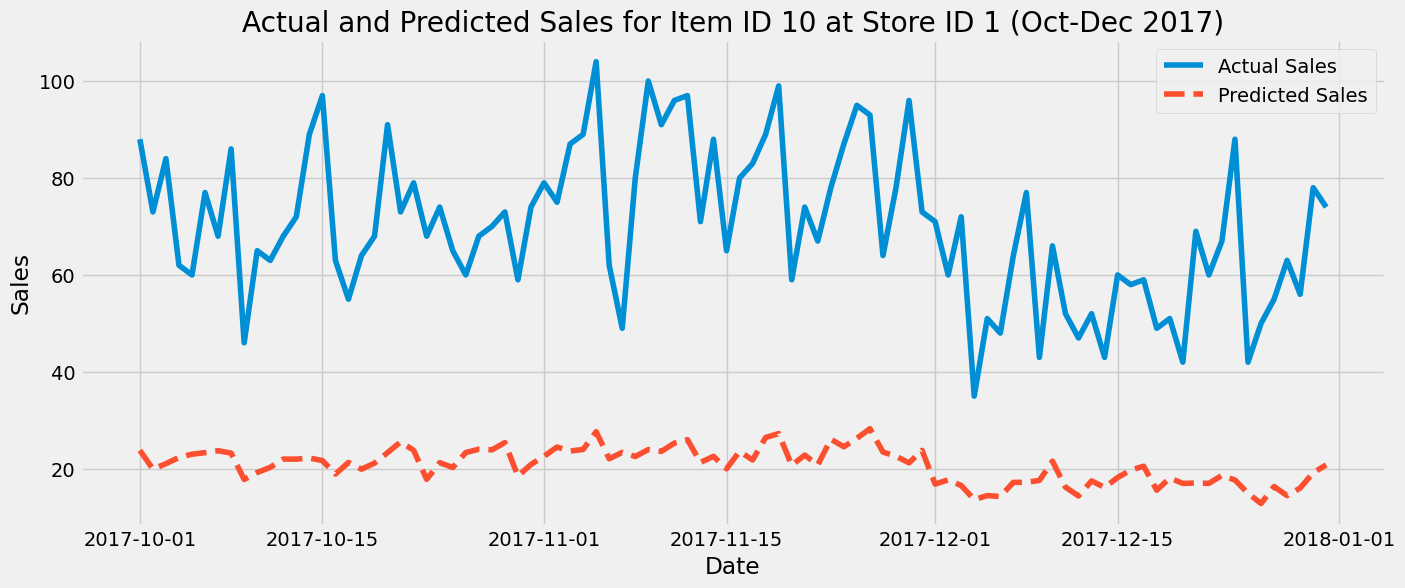

In [127]:
# YOUR CODE
sales.drop("date", axis=1,inplace=True)
filtered_data = sales[(sales['store'] == 1) & (sales['item'] == 10) & 
                      (sales.index >= '2017-10-01') & (sales.index <= '2017-12-31')]

filtered_data['predicted_sales'] = y_pred[:len(filtered_data)]

plt.figure(figsize=(15, 6))
plt.plot(filtered_data['sales'], label='Actual Sales')
plt.plot(filtered_data['predicted_sales'], label='Predicted Sales', linestyle='--')
plt.title('Actual and Predicted Sales for Item ID 10 at Store ID 1 (Oct-Dec 2017)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


---